### Imports

In [123]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
from scipy.stats import shapiro

In [124]:
plt.rcParams["figure.figsize"] = (20,10)

## Problem Statement

The ability to forecast sales for any business is of crucial importance. With an insight on what the expected sales would be in the near future the businesses can plan accordingly. The managers are able to schedule shifts, allocate resources, stock inventory etc based on the forecast. 

A lot of businesses have a somewhat homogenous sales trend over time except for in the Holiday seasons. Being able to accurately predict the sales in the Holiday seasons is even more important. The challenge in predicting Holiday sales is that there isn't much data available. This problem can be applied to any industry/business whose sales are affected by the holiday seasons. They can use this information to manage resources, complete inventory, launch applicable promotions etc.

## Approach

I want to approach this problem by participating in a kaggle competion where the task is to predict the weekly sales of the departments of 45 walmart stores across the US. 

The objective of this project is to take part in the competition and attempt to get to the top of the leaderboard using machine learning techniques.

### Competition Overview

You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

### Evaluation metric

The evaluation metric is a Weight Mean Absolute error where 5 times weight is given to the Holiday weeks.
If this is achieved then a similar approach can be used for other industries as well.

![Error_image](e.jpg)

## Data source

The data that I will be using is of 45 Walmart stores. The dataset can be easily downloaded from [Kaggle](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data). It contains department wise weekly sales for each store for over 2 years, along with 12 features.

The data in available as 4 tables:

- **Train Sales** - Store wise department wise weekly sales for 2 years

- **Test Sales** - Store, department and dates 

- **Features** - This contains the stores region characteristics like fuel price, temperature, Consumer affluence, unemployment percentage and active promotions over time

- **Store** - This defines the type and size of each store.

In [125]:
features = pd.read_csv('walmart-recruiting-store-sales-forecasting/features.csv',parse_dates=[1])
stores = pd.read_csv('walmart-recruiting-store-sales-forecasting/stores.csv')
test = pd.read_csv('walmart-recruiting-store-sales-forecasting/test.csv',parse_dates=[2])
train = pd.read_csv('walmart-recruiting-store-sales-forecasting/train.csv',parse_dates=[2])

**TRAIN & TEST**

Looking at the first 5 rows of both test and train tables

In [126]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [127]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


- Store - the store number
- Dept - the department number
- Date - the week
- Weekly_Sales -  sales for the given department in the given store (Only present in train data)
- IsHoliday - whether the week is a special holiday week

In [128]:
train_shape = train.shape
print('Train table has %d columns and %d observations' % (train_shape[1],train_shape[0]))
print('Out of these %0.2f percent are Holidays' % (sum(train.IsHoliday == True)*100/train_shape[0]))

Train table has 5 columns and 421570 observations
Out of these 7.04 percent are Holidays


In [129]:
test_shape = test.shape
print('Test table has %d columns and %d observations' % (test_shape[1],test_shape[0]))
print('Out of these %0.2f percent are Holidays' % (sum(test.IsHoliday == True)*100/test_shape[0]))

Test table has 4 columns and 115064 observations
Out of these 7.76 percent are Holidays


**Stores**

In [130]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


- Store - the store number
- Type - *Description not given*
- Size - *Description not given but is self explanatory* 

In [131]:
print("The stores table has %d rows, one for each store."% (stores.shape[0]))
print("Each row has info on the type and size of the store " )

The stores table has 45 rows, one for each store.
Each row has info on the type and size of the store 


**Features**

In [132]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


- Temperature - average temperature in the region
- Fuel_Price - cost of fuel in the region
- MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
- CPI - the consumer price index
- Unemployment - the unemployment rate
- IsHoliday - same as in train and test

In [133]:
print("The features table has %d rows, one for each store for each week in both test and train data. Each row has store and time specific information of each store" % (features.shape[0]))

The features table has 8190 rows, one for each store for each week in both test and train data. Each row has store and time specific information of each store


# Data Wrangling

To conduct data wrangling some data discovery will need to be done. This is necessary in order to identify the approaches that need to be undertaken.

The first step to to that is to join the tables to create one workable dataset.

## Joining the tables

The data needs to be joined together to do the relational analysis on the different features

- The train and test tables can be left joined with the stores table with key on `Store`
- The resultant table can be left joined again with the features table on `Store` & `Date` columns

In [134]:
train_data = pd.merge(left=pd.merge(left=train,right=stores,how='left'),right=features,how='left',on=['Store','Date','IsHoliday'])
test_data = pd.merge(left = pd.merge(left=test,right=stores,how='left'),right=features,how='left',on = ['Store','Date','IsHoliday'])

In [135]:
train_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [136]:
test_data.head()

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573
1,1,1,2012-11-09,False,A,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573
2,1,1,2012-11-16,False,A,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573
3,1,1,2012-11-23,True,A,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573
4,1,1,2012-11-30,False,A,151315,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573


In [137]:
print('train_data has %d rows' % len(train_data))
print('test_data has %d rows' % len(test_data))
print('Which is consistent with the number of rows we had in the train and test tables')

train_data has 421570 rows
test_data has 115064 rows
Which is consistent with the number of rows we had in the train and test tables


## Approach

Perform a thorough exploratory analysis to try to understand the data. This understanding will be used to make informed decisions during the modeling phase.

Due to the high variation in sales in the Holiday weeks, it will be a challenge to predict these accurately. The initial thought is to use a Gradient Boosting algorithm so that more weight can be applied to these durations.

### Some sanity checks on the data

#### Checking to see if the train features and the stores files contains information on all the stores that are present in the train data

In [138]:
np.all(train.Store.unique() == features.Store.unique())

True

In [139]:
np.all(train.Store.unique() == stores.Store.unique())

True

#### Checking to see if the features data consists of all dates that are in the test and train data

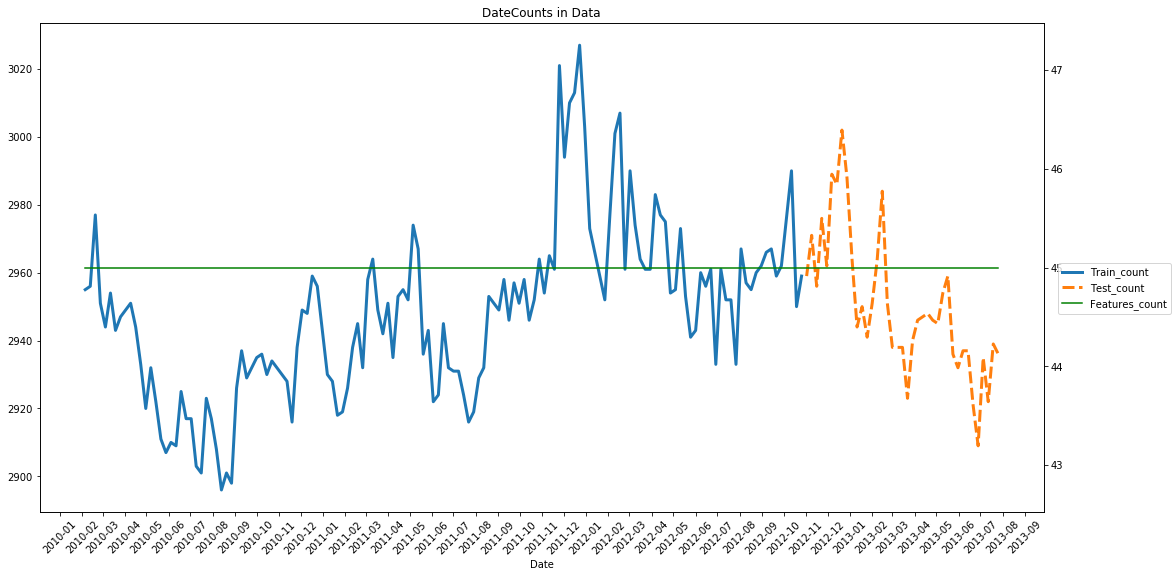

In [140]:
train_date_counts = train.Date.value_counts().reset_index()
test_date_counts = test.Date.value_counts().reset_index()
features_date_counts = features.Date.value_counts().reset_index()
date_counts_df=features_date_counts.merge(train_date_counts,how='outer',on='index').merge(test_date_counts,how='outer',on='index')
date_counts_df.columns = ['Date','Features_count','Train_count','Test_count']
date_counts_df.set_index('Date',inplace=True)

from matplotlib.dates import DateFormatter
myFmt = DateFormatter('%m%y')

fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(111)
ax.set_title('DateCounts in Data')
sns.lineplot(data=date_counts_df[['Train_count','Test_count']],linewidth=3,legend=None,ax=ax)
ax2=plt.twinx()
sns.lineplot(data=date_counts_df['Features_count'],color='green',legend=None, ax=ax2,label='Feature_count')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.get_xticklabels(), rotation=45)
fig.legend(labels = ('Train_count','Test_count','Features_count'), loc='center right', fancybox=True)
plt.show()

The graph shows that:
1. The test data starts on the dates where the train data ends
2. The features table has dates for all of the data (both train and test)

In [141]:
train_data.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289
std,12.785297,30.492054,22711.183519,60980.583328,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296
min,1.000000,1.000000,-4988.940000,34875.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000
25%,11.000000,18.000000,2079.650000,93638.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000
50%,22.000000,37.000000,7612.030000,140167.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000
75%,33.000000,74.000000,20205.852500,202505.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000


On first glance, we notice the following issues in the data.
1. The minimum Weekly_Sales is negative
2. Missing values in Markdown columns - This was expected because it was mentioned in the data description. 
3. There appears to be a huge skew in the Weekly_Sales. The max value is very much larger than the 75% percentile. This can also be an outlier. 
4. There are negative values in the Markdown2 and Markdown3 columns. A similar skew can be noted in all the Markdown columns as well.

**We will try to address each of these issues in the same order** 

### 1. Negative Weekly_Sales

The minimum weekly_sales is negative which means that there are negative values in the sales. The competition posters(Walmart) have not given any reason as to why that would be. A logical reasoning would be that these would be weeks where 

In [142]:
neg_index = train_data.Weekly_Sales<0
num_negative_ws = sum(neg_index)
print('There are %d negative values which is approximately %0.3f perc of all of the data' % (num_negative_ws,(num_negative_ws*100)/len(train_data)))

There are 1285 negative values which is approximately 0.305 perc of all of the data


This doesnt seem a lot. Lets investigate further to check if a pattern emerges

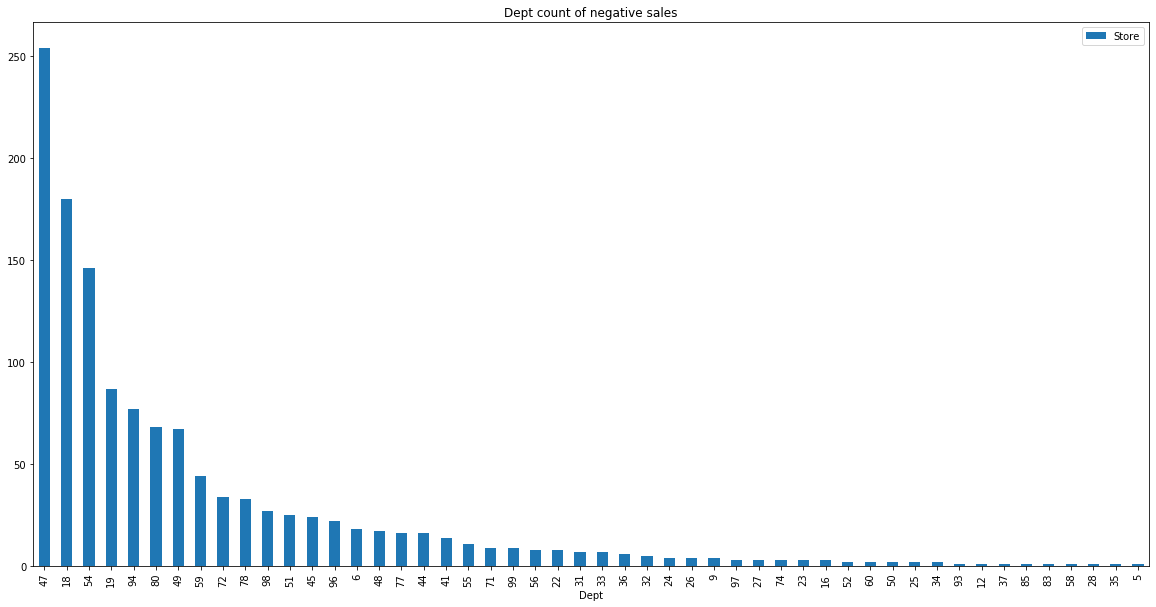

In [143]:
_ = train_data[neg_index][['Store','Dept']].groupby(['Dept']).count().sort_values('Store',ascending=False).plot(kind='bar')
_ = plt.title('Dept count of negative sales')

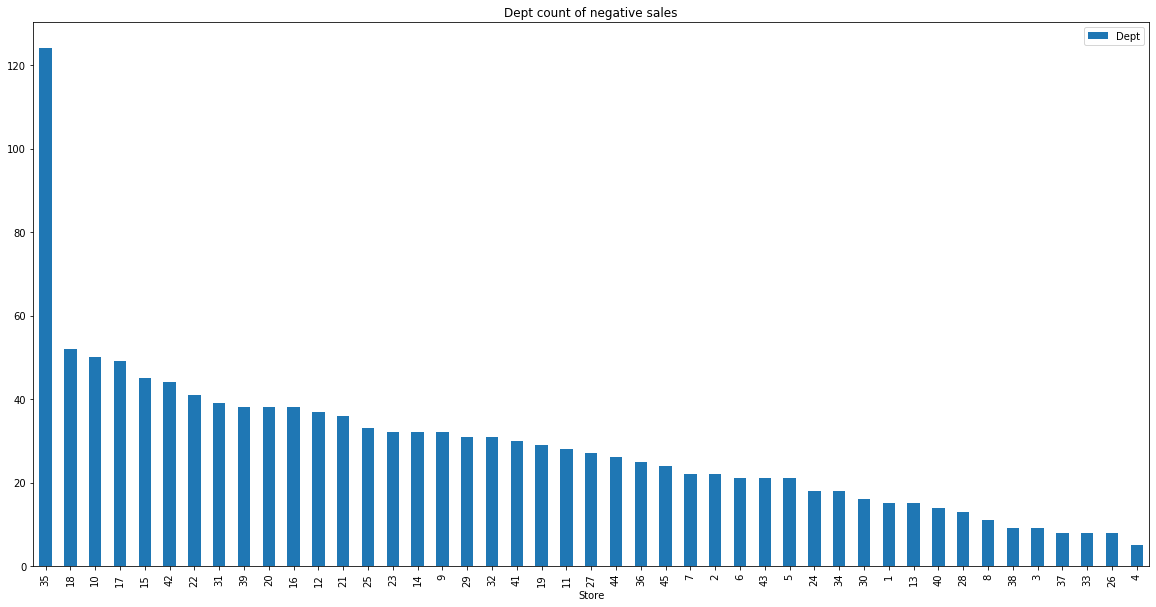

In [144]:
_ = train_data[neg_index][['Store','Dept']].groupby(['Store']).count().sort_values('Dept',ascending=False).plot(kind='bar')
_ = plt.title('Dept count of negative sales')


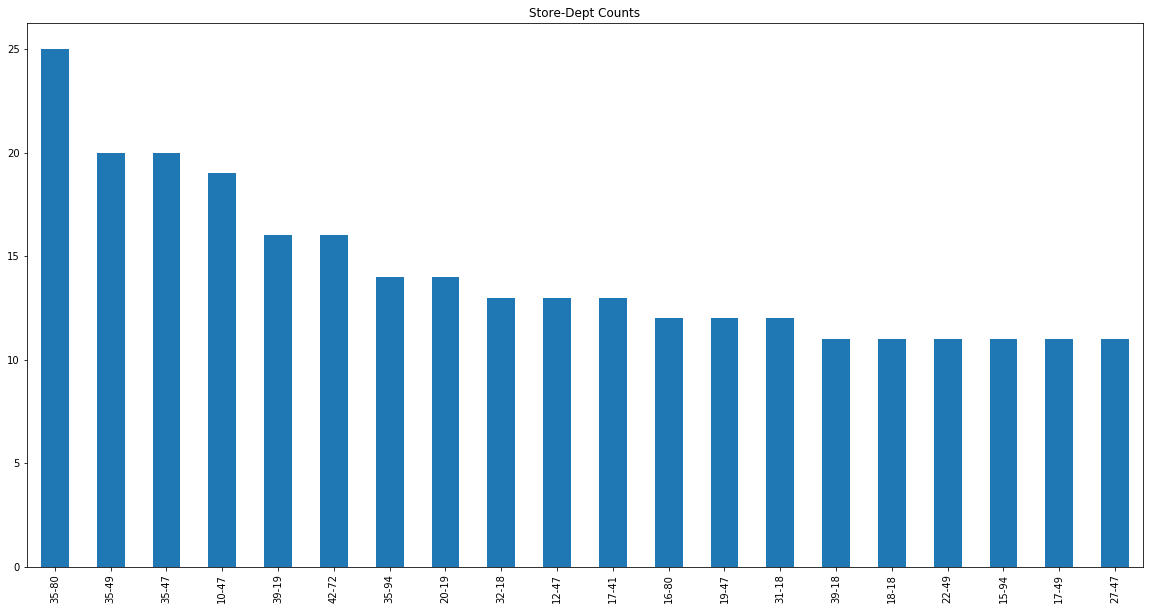

In [145]:
neg_table = train_data[neg_index][['Store','Dept']]
neg_table['Store-Dept']=neg_table['Store'].astype(str) + '-'+neg_table['Dept'].astype(str)
_ = neg_table['Store-Dept'].value_counts().head(20).plot(kind='bar')
_ = plt.title('Store-Dept Counts')

**Amongst departments 47 consistently performs poorly. And among stores, store 35. However the counts are too low to do anything for now.**

### 2. Missing Values in the Tables

Text(0.5, 1.0, 'Feature Missing Values %age in Test and Train data')

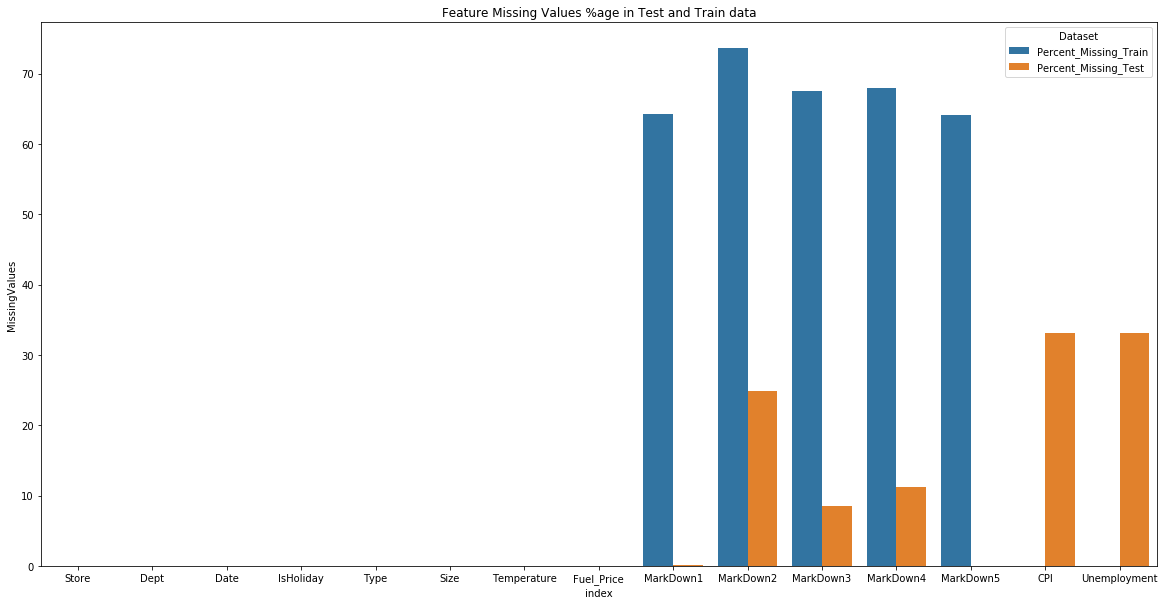

In [146]:
Nan_percent = train_data.isnull().sum()*100/len(train_data)
train_datatype = train_data.dtypes

train_dataset_summary = pd.DataFrame({"Percent_Missing":Nan_percent.round(2),
                             "Datatypes":train_datatype})

Nan_percent = test_data.isnull().sum()*100/len(test_data)
test_datatype = test_data.dtypes

test_dataset_summary = pd.DataFrame({"Percent_Missing":Nan_percent.round(2),
                             "Datatypes":test_datatype})

missing_data = pd.merge(left=train_dataset_summary.Percent_Missing.reset_index(),right=test_dataset_summary.Percent_Missing.reset_index(),how='inner',on='index')

missing_data.set_index('index',inplace=True)
missing_data.columns = ['Percent_Missing_Train','Percent_Missing_Test']

md=pd.melt(missing_data.reset_index(),id_vars='index',value_vars=['Percent_Missing_Train','Percent_Missing_Test'],var_name='Dataset',value_name='MissingValues')

sns.barplot(data=md,x='index',y='MissingValues',hue='Dataset').set_title('Feature Missing Values %age in Test and Train data')

Only markdown columns have missing values in the train data for the MarkDown columns. However, the test data contains missing values for some Markdown columns and a significant amount in the CPI and Unemployment columns.  

In [147]:
train_ts_data = train_data.set_index('Date')
test_ts_data = test_data.set_index('Date')

In [148]:
def perc_missing(series):
    return sum(series)*100/len(series)

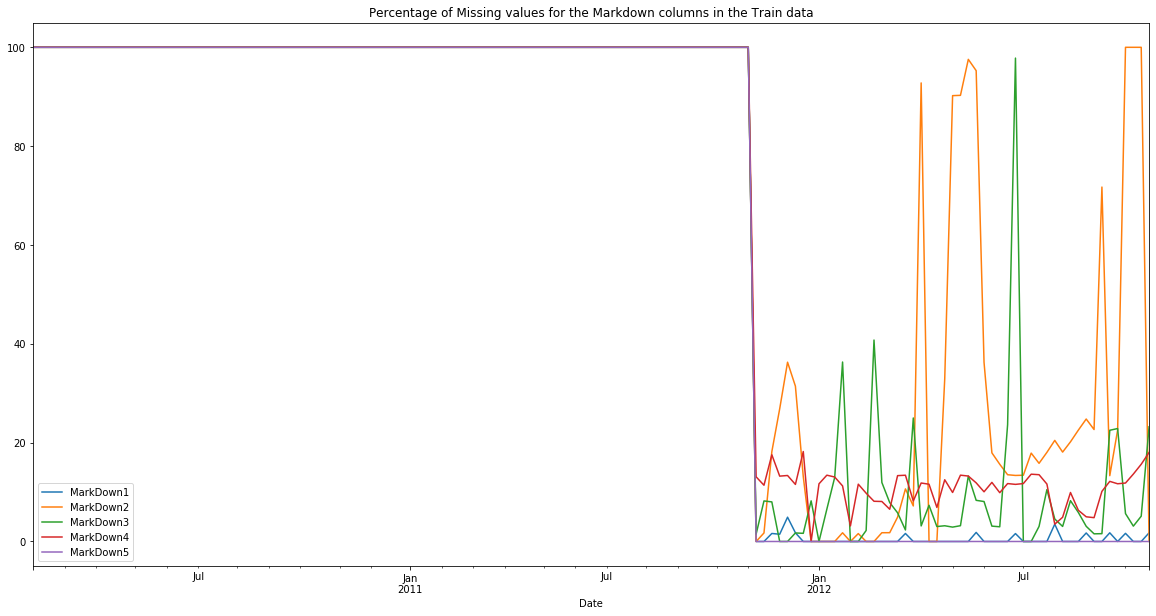

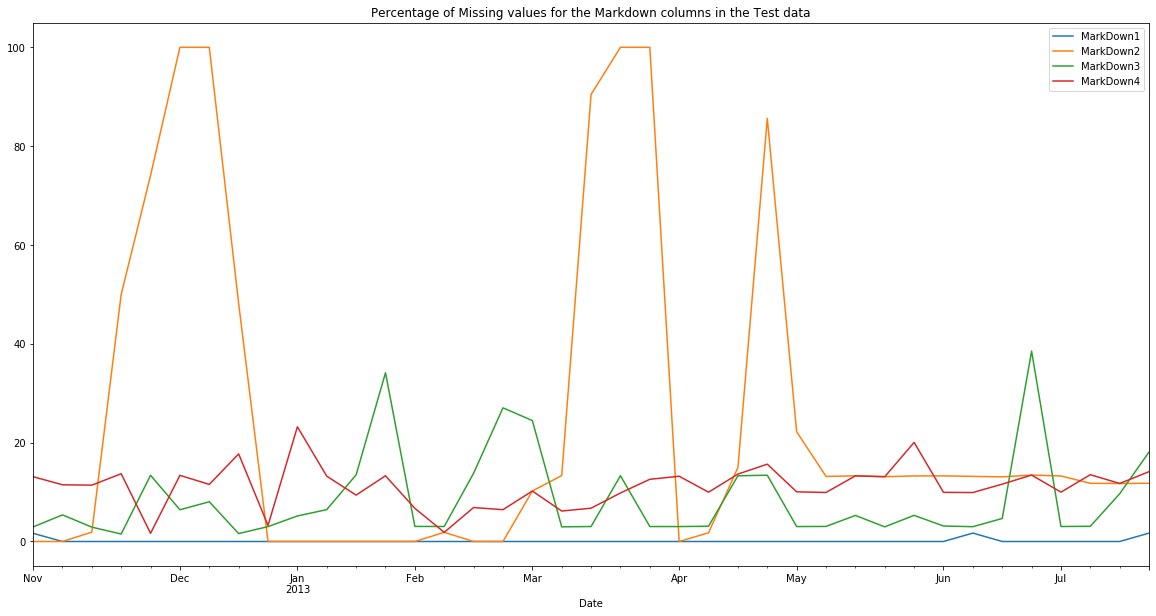

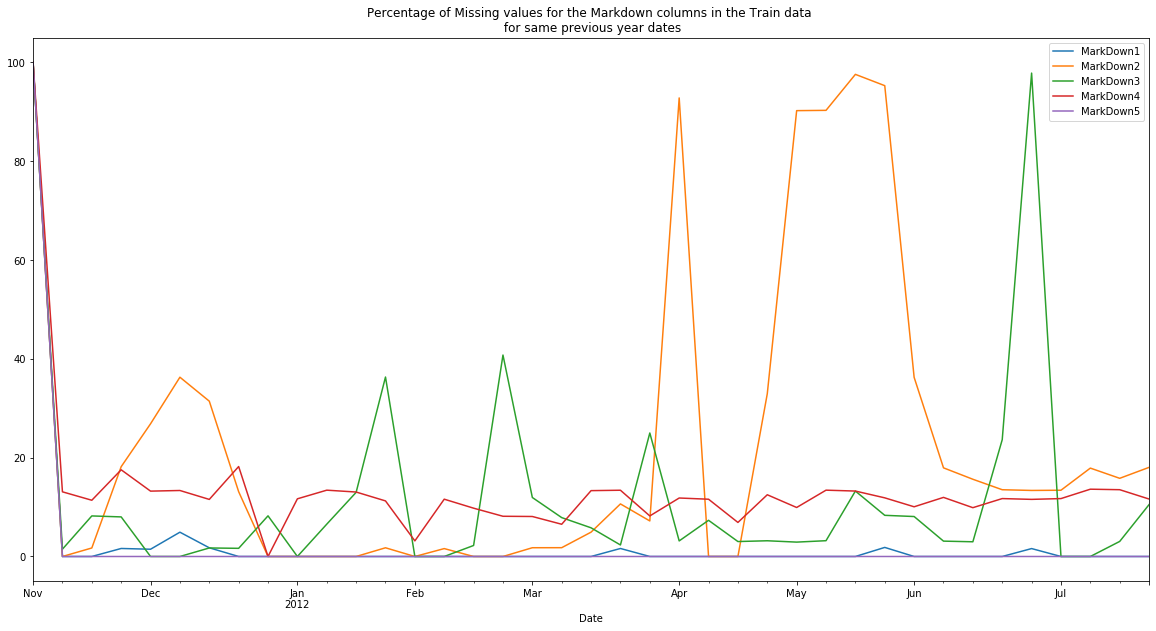

In [149]:
train_ts_data[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].apply(pd.isnull).groupby('Date').agg(perc_missing).plot(title= 'Percentage of Missing values for the Markdown columns in the Train data')
test_ts_data[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].apply(pd.isnull).groupby('Date').agg(perc_missing).plot(title= 'Percentage of Missing values for the Markdown columns in the Test data')
train_ts_data.loc['Nov-2011':'Jul-2012',['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].apply(pd.isnull).groupby('Date').agg(perc_missing).plot(title= 'Percentage of Missing values for the Markdown columns in the Train data \n for same previous year dates')

1. Graph 1 & 2: The above graphs depict that all values for the Markdown columns are missing before Nov-11 while some are missing in the train data after that as well.
2. Graph 2 & 3: Percentage of Missing values for the Markdown columns in the Train data for same next year dates in the test data (for comparison)

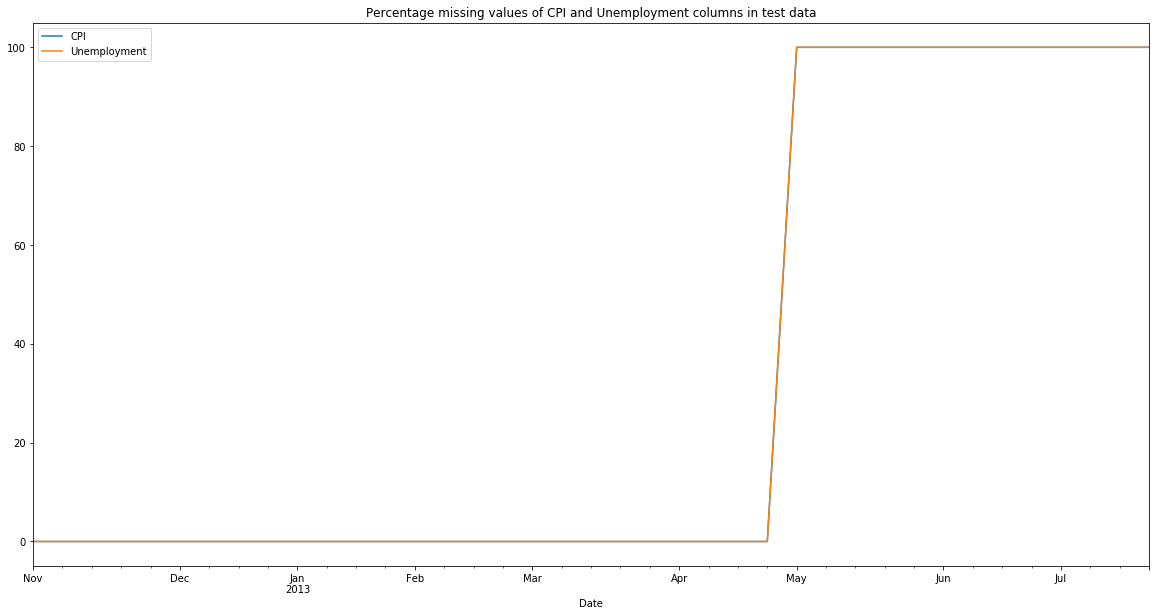

In [150]:
test_ts_data[['CPI','Unemployment']].apply(pd.isnull).groupby('Date').agg(perc_missing).plot(title = 'Percentage missing values of CPI and Unemployment columns in test data')

**Takeaway**

1. In the training data Markdowns are only available for 9 months. The test data is also for a duration of 9 months. This makes the Markdown columns not a very effective feature since the yearly trend will not be available for these features.
2. Unemployement and CPI are missing for a third of the test data. This is also problem that will need to be dealt to make model predictions.
3. There isnt any systematic trend in the missing values in any of the columns

### Actionables from data wrangling

- Will need to further analyse Markdown columns to see if they can be used for modeling purposes.
- Will impute 0 in the missing values for now for all columns. Maybe a better strategdy can be devised later on.

## Exploratory Data Analysis

### Weekly_Sales distribution

Lets look at the distribution of the Weekly_Sales - The target feature

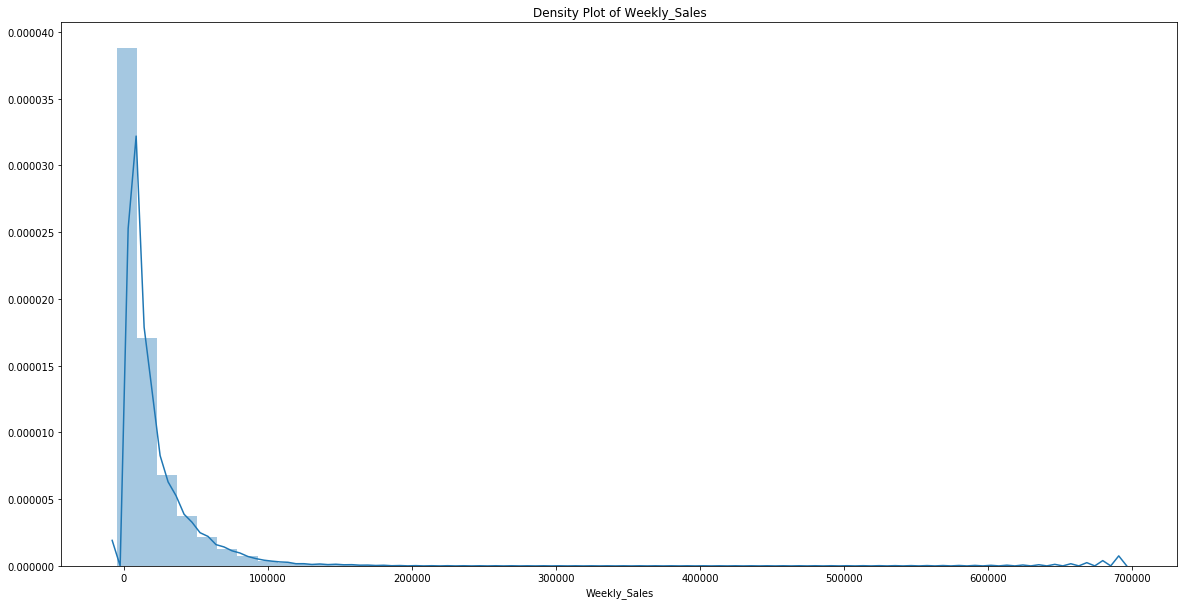

In [151]:
plt.title('Density Plot of Weekly_Sales')
sns.distplot(train_data.Weekly_Sales)

As discussed earlier The distribution of weekly_Sales is very skewed. This limits the effectiveness of most of the parametric machine learning models which rely on the assumption that the distribution is normal.

**Lets look at the distribution of log scaled weekly_sales**

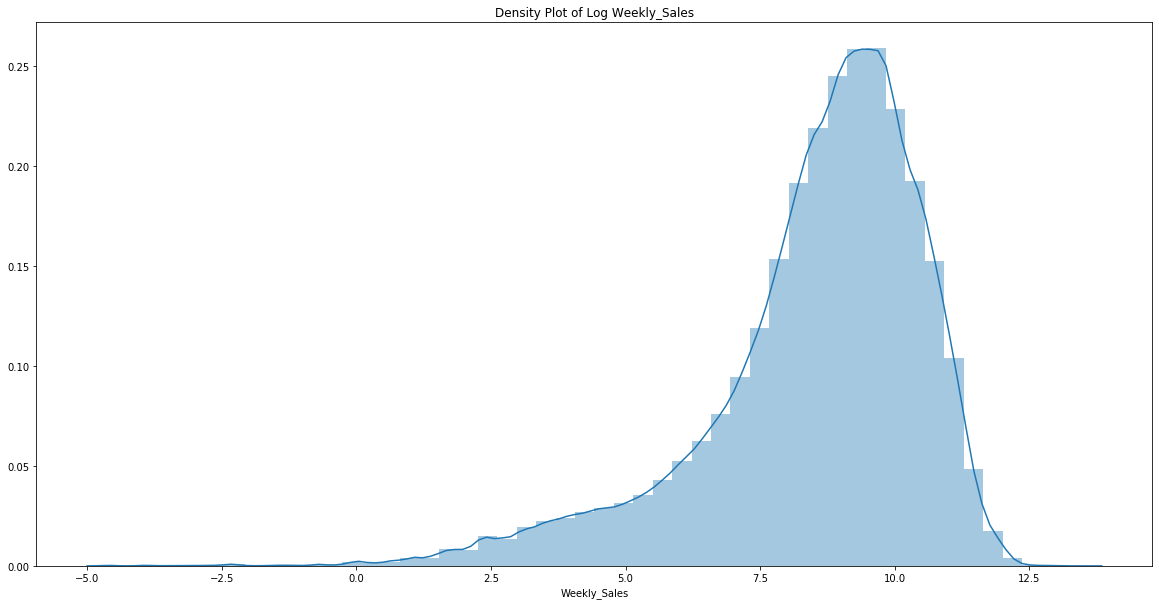

In [152]:
log_weekly_sales = np.log(train_data.Weekly_Sales[train_data.Weekly_Sales>0])
plt.title('Density Plot of Log Weekly_Sales')
sns.distplot(log_weekly_sales)

This looks somewhat normally distributed but there is still a skew to the left. Lets look at the summary statistics.

I would assume that the distribution of `log(weekly_sales)` is (or close enough to being) a normal distribution

Lets test this hypothesis using some statistical tests. Lets plot the empirical cdf plot of log_weekly_sales and compare it with the cdf of a normal distribution

In [153]:
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n

    return x, y


In [154]:
norm_dist = np.random.normal(loc=np.mean(log_weekly_sales),scale = np.std(log_weekly_sales),size=len(log_weekly_sales))

In [155]:
x,y = ecdf(log_weekly_sales)
x_norm,y_norm = ecdf(norm_dist)

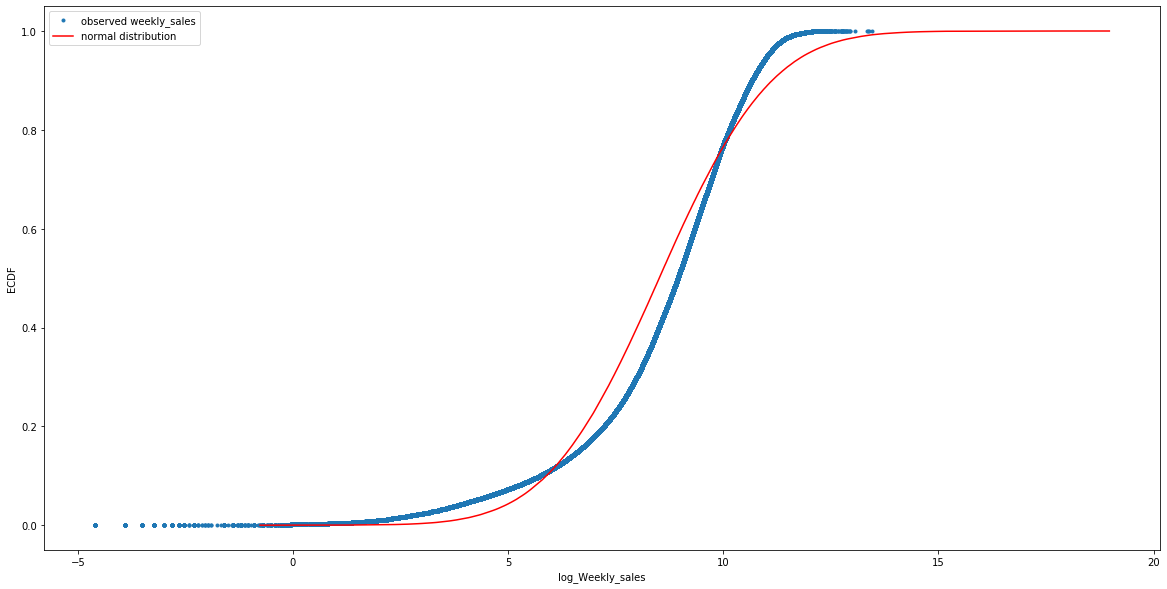

In [156]:
_ = plt.plot(x,y,linestyle='none',marker='.',label='observed weekly_sales')
_ = plt.plot(x_norm,y_norm,color='red',label = 'normal distribution')
_ = plt.ylabel('ECDF')
_ = plt.xlabel('log_Weekly_sales')
_ = plt.legend(loc='upper left')

As we can see that even though the distribution looks close to being normal (from the plot), the ecdf shows that they are clearly very different.

Lets apply the shapiro-wilk tests to both weekly_sales and log(weekly_sales). The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.

Performing the test on all of the data takes a long time so lets sample from the original data.

In [157]:
W,p = shapiro(log_weekly_sales.sample(5000))
print('Test Statistic: ',round(W,4))
print('p-value: ',p)

Test Statistic:  0.908
p-value:  0.0


The The p-values is 0, so we can reject the null hypothesis and conclude that the data did not come from a normal distribution

### Implication of test result

We can see that neither the Weekly_sales nor the log transformed weekly sales are normally distributed. This would mean that in order to use parametric machine learning methods some other transformation would need to be appied in order to enforce normality. Or non parametric methods can be used like Tree based models.

### Weekly_sales trend over time

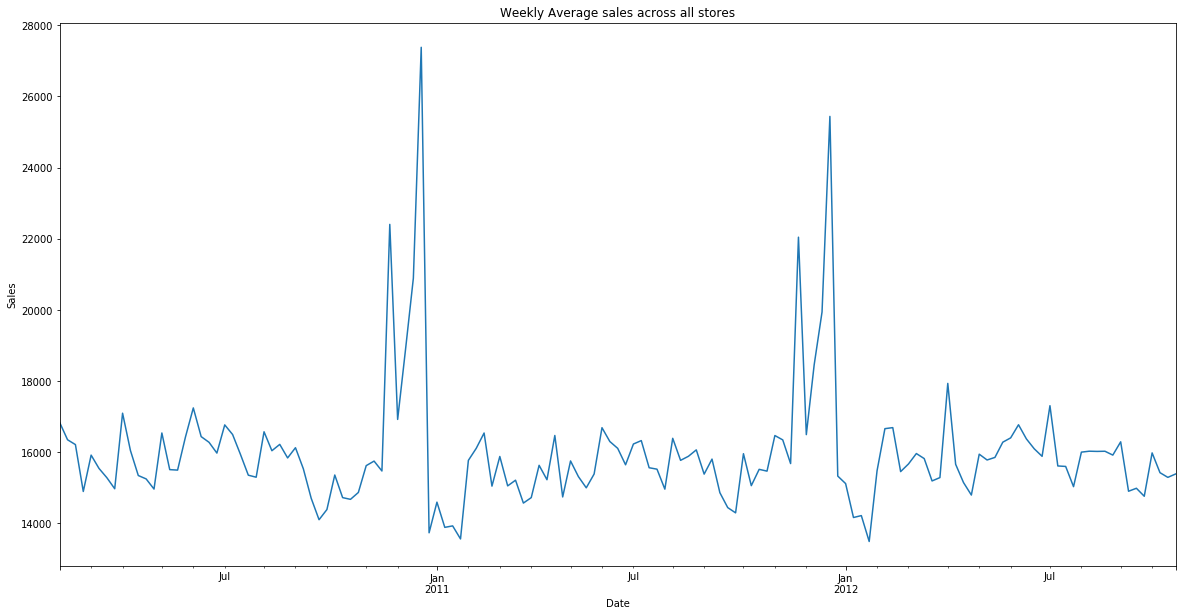

In [158]:
train_data.groupby('Date').Weekly_Sales.mean().plot()
_ = plt.ylabel('Sales')
_ = plt.title('Weekly Average sales across all stores')

We see the trend of avg Weekly sales over time. One thing to notice is that the sales spikes near the christmas season. Lets add markers on the holiday dates to determine which holidays have more impact and which have less.

In [159]:
sb_dates = pd.to_datetime(['2010-02-12','2011-02-11','2012-02-10','2013-02-08'])
labor_dates = pd.to_datetime(['2010-09-10','2011-09-09','2012-09-07','2013-09-06'])
thanksgiving_dates = pd.to_datetime(['2010-11-26','2011-11-25','2012-11-23','2013-11-29'])
christmas_dates = pd.to_datetime(['2010-12-31','2011-12-30','2012-12-28','2013-12-27'])
all_holiday_dates = [sb_dates,labor_dates,thanksgiving_dates,christmas_dates]
colors = ['red','green','purple','orange']
labels = ['Super Bowl','Labor Day','Thanksgiving','Christmas']

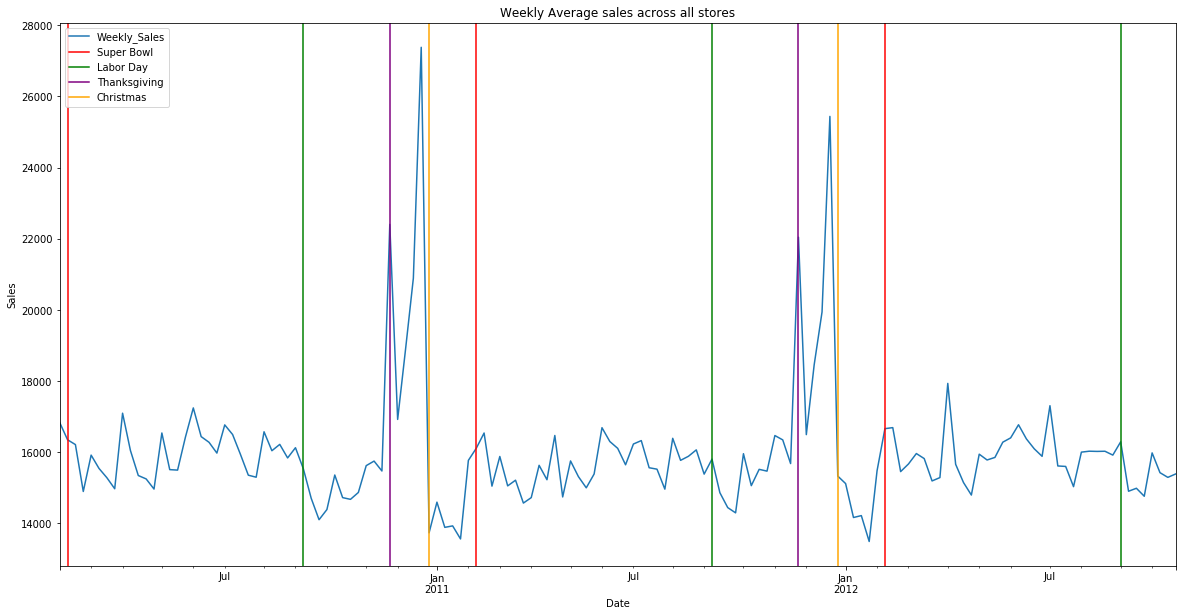

In [160]:
train_data.groupby('Date').Weekly_Sales.mean().plot()
_ = plt.ylabel('Sales')
_ = plt.title('Weekly Average sales across all stores')

for holiday,color,l in zip(all_holiday_dates,colors,labels):
    for i,date in enumerate(holiday):
        if i != 0:
            l=None
        _ = plt.axvline(date,c=color,label=l)
_ = plt.legend(loc='upper left')


**Important takeaways from the above plot**

1. It can be seen that the Weekly sales are more affected by Thanksgiving and Christmas holidays and less by Superbowl and labor day.
2. The sales sharply drop after all holidays except SuperBowl.
3. There is an offset in the weekly_sales for christmas. I can think of 2 explanations for this.
        1. The sales occur a week before the actual holiday
        2. The values of the sales are provided on a weekly basis. But the holiday is on a day. The offset maybe due to the placement of that day within the week


*Lets do the same for log_weekly_sales*

In [161]:
log_train_data = train_data[train_data.Weekly_Sales>0]
log_train_data['log_weekly_sales'] = np.log(log_train_data.Weekly_Sales)

C:\Users\shahb\AnacondaPython\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


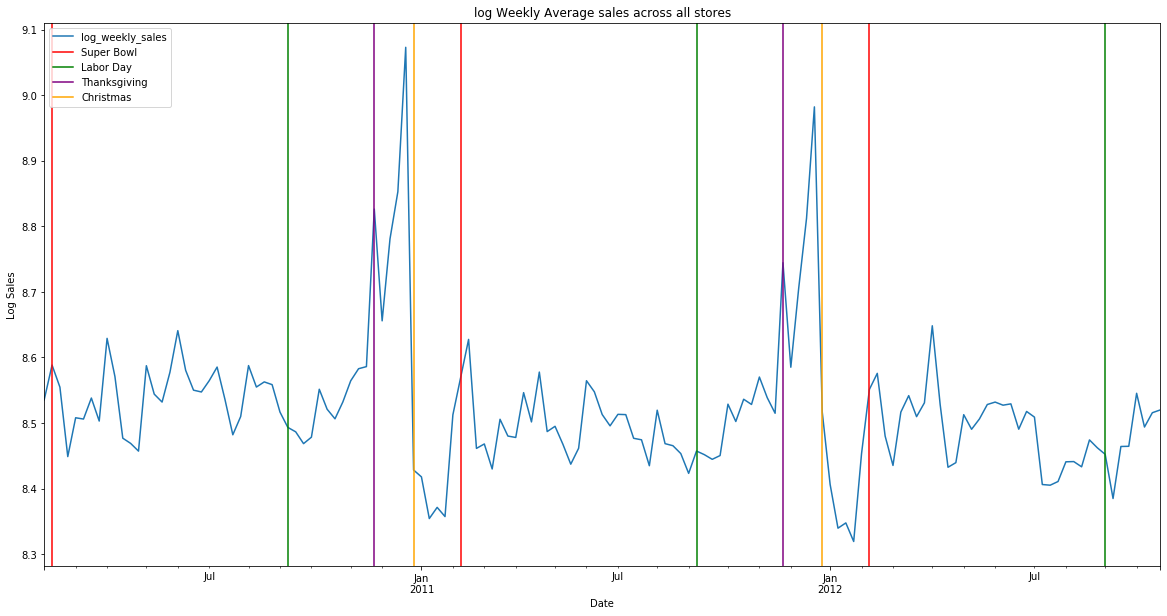

In [162]:
log_train_data.groupby('Date').log_weekly_sales.mean().plot()
_ = plt.ylabel('Log Sales')
_ = plt.title('log Weekly Average sales across all stores')

for holiday,color,l in zip(all_holiday_dates,colors,labels):
    for i,date in enumerate(holiday):
        if i != 0:
            l=None
        _ = plt.axvline(date,c=color,label=l)
_ = plt.legend(loc='upper left')

The log scaled weekly sales trend is similar to the original series and the same takeaways apply here as well. 

## Analysis of weekly_Sales with other features

### Weekly_Sales & Type

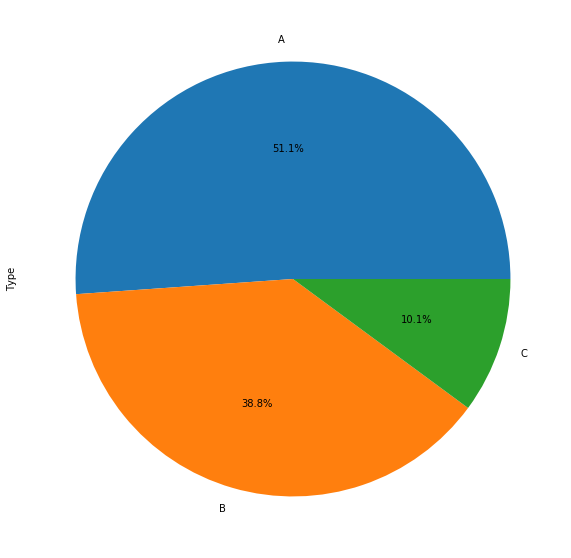

In [163]:
train_data['Type'].value_counts().plot(kind='pie',autopct = "%1.1f%%")

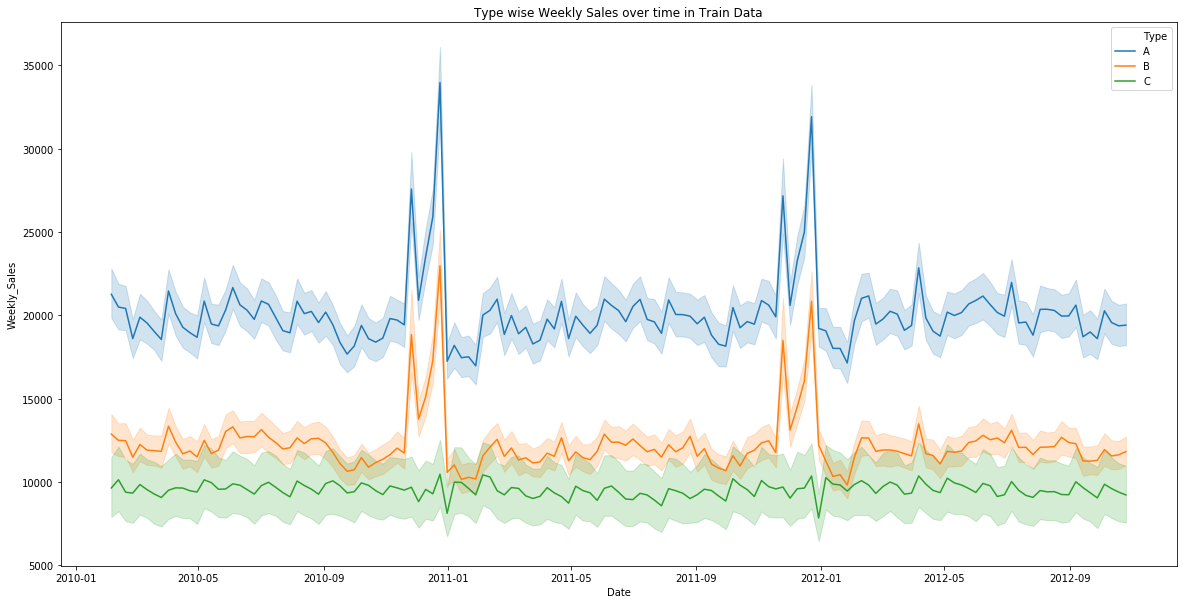

In [164]:
sns.lineplot(x='Date',y='Weekly_Sales',hue='Type',data = train_data).set_title('Type wise Weekly Sales over time in Train Data');

We see that the `Type` feature gives a very distinct difference in the weekly_sales of the store. Also, `Type==C` is almost completely void of any sensitivity due to the holiday seasons

## CPI - Consumer Price Index & Unemployment

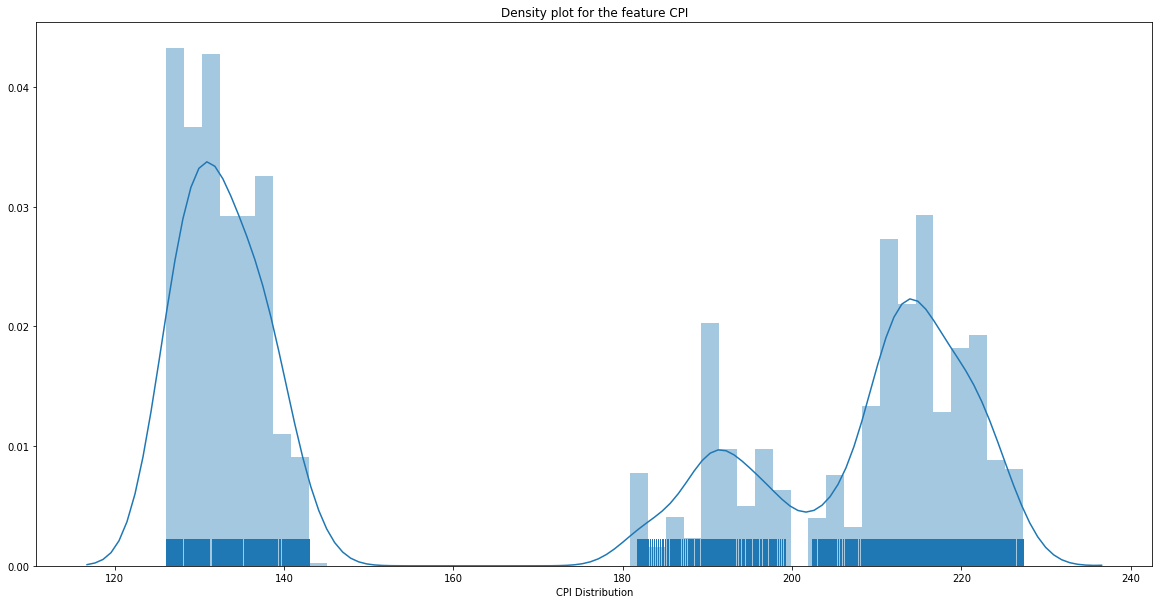

In [165]:
sns.distplot(a=train_data['CPI'],axlabel='CPI Distribution',rug=True).set_title('Density plot for the feature CPI');

We can see a trimodal distribution of the CPI values. Lets try to convet these into ordinal values i.e. LowCPI,MedCPI and HighCPI and then analyze their relationship with the weekly sales.

In [166]:
train_data['CPI_cat'] = np.where(train_data.CPI<160,'LowCPI',np.where(train_data.CPI<200,'MedCPI','HighCPI'))

Text(0.5, 1.0, 'Weekly_Sales VS Date - Split over 3 CPI Categories')

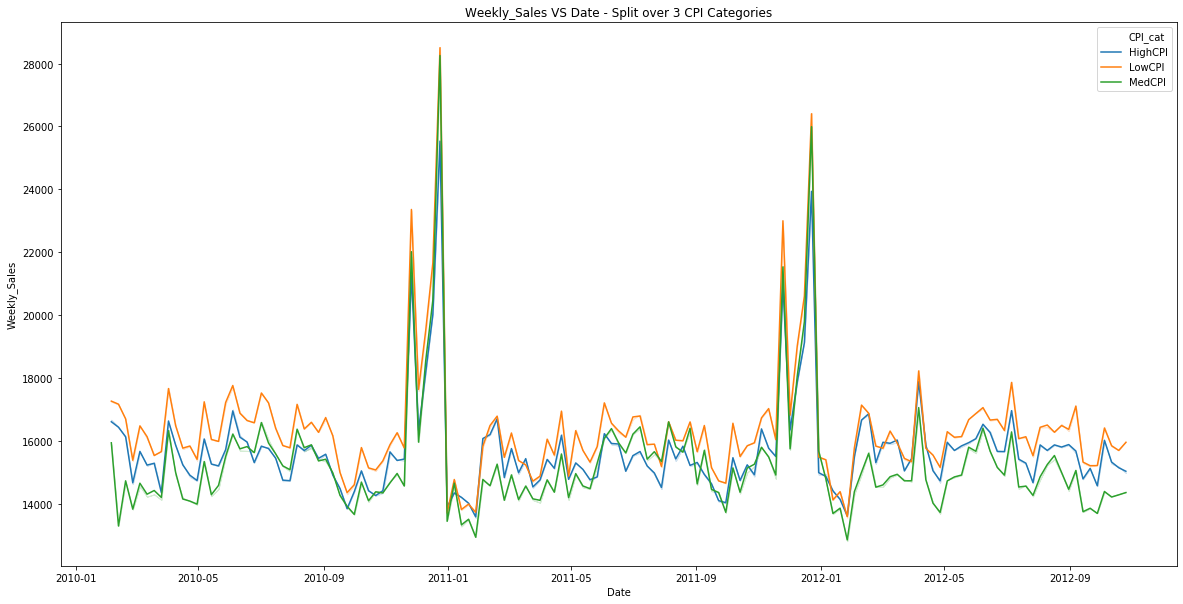

In [167]:
sns.lineplot(x='Date',y='Weekly_Sales',hue='CPI_cat',data = train_data,ci=False).set_title('Weekly_Sales VS Date - Split over 3 CPI Categories')

We can see that for LowCPI weekly sales are consistently higher than both Med and High. However the difference between Med and High isnt quite noticeble. Lets try this again with two categories of CPI only i.e. LowCPI and HighCPI 

In [168]:
train_data['CPI_cat'] = np.where(train_data.CPI<160,'LowCPI','HighCPI')

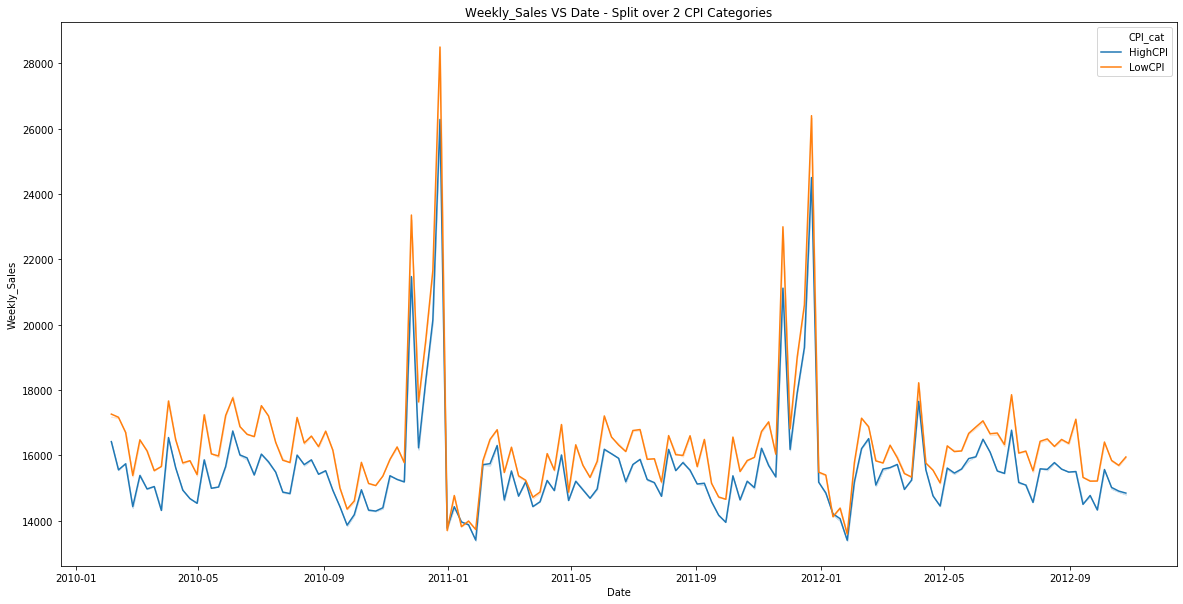

In [169]:
sns.lineplot(x='Date',y='Weekly_Sales',hue='CPI_cat',data = train_data,ci=False).set_title('Weekly_Sales VS Date - Split over 2 CPI Categories');

This new feature now better distinguishes between the Weekly_Sales therefore has potential to be a good feature in our final model. However, a reminder here is that about 30% of these values are missing in the test data.

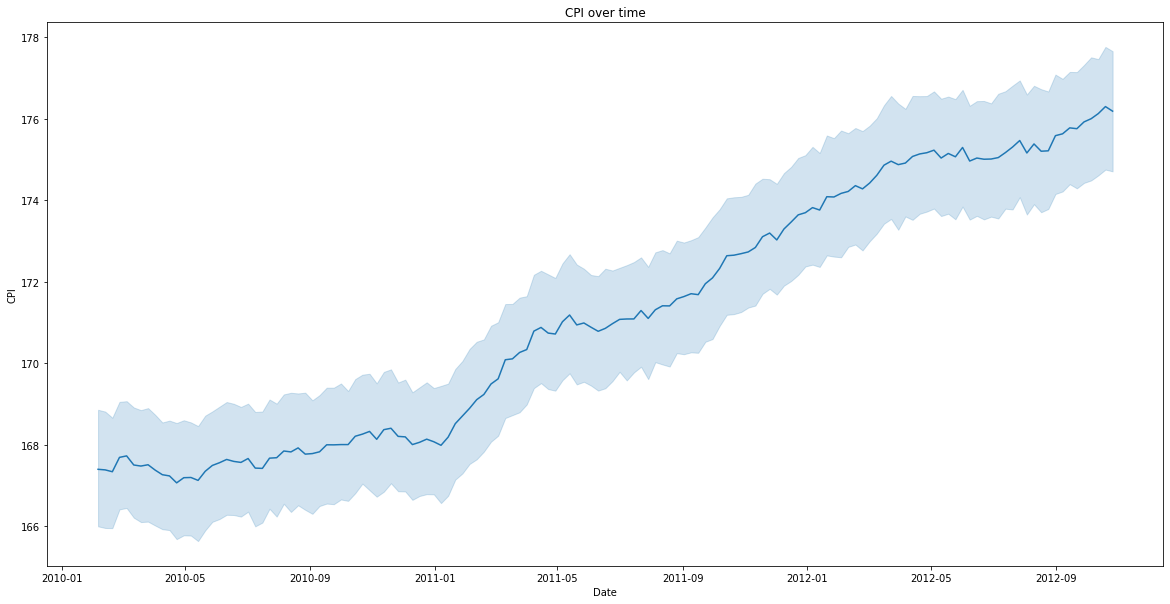

In [170]:
sns.lineplot(x='Date',y='CPI',data = train_data).set_title('CPI over time');

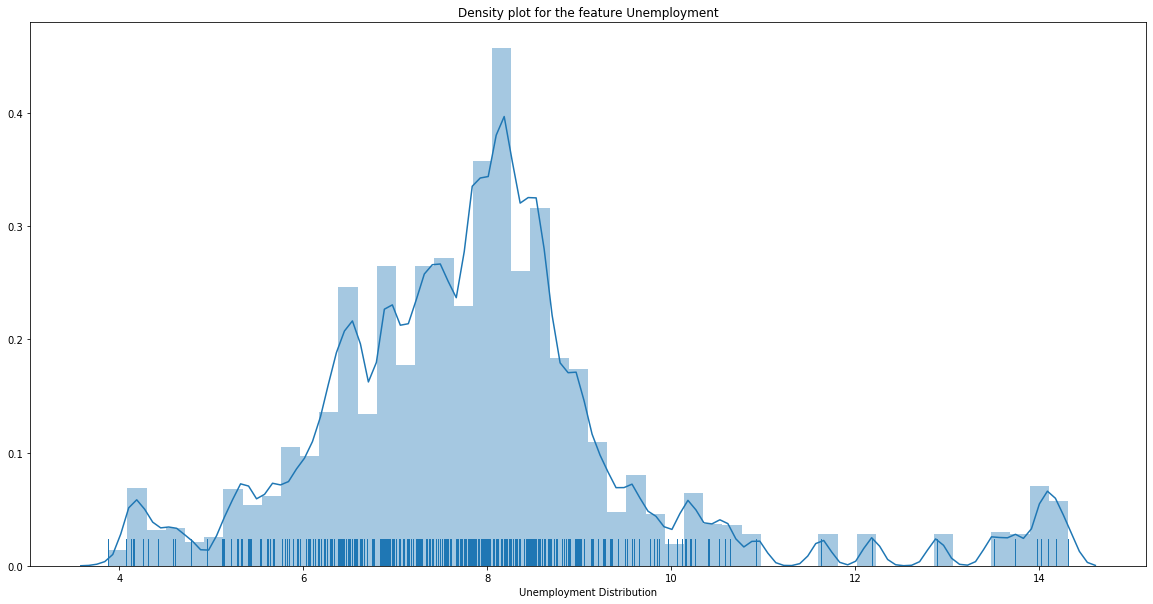

In [171]:
sns.distplot(a=train_data['Unemployment'],axlabel='Unemployment Distribution',rug=True).set_title('Density plot for the feature Unemployment');

Text(0.5, 1.0, 'RegPlot of Weekly_Sales vs Unemployment Weekly_Averages')

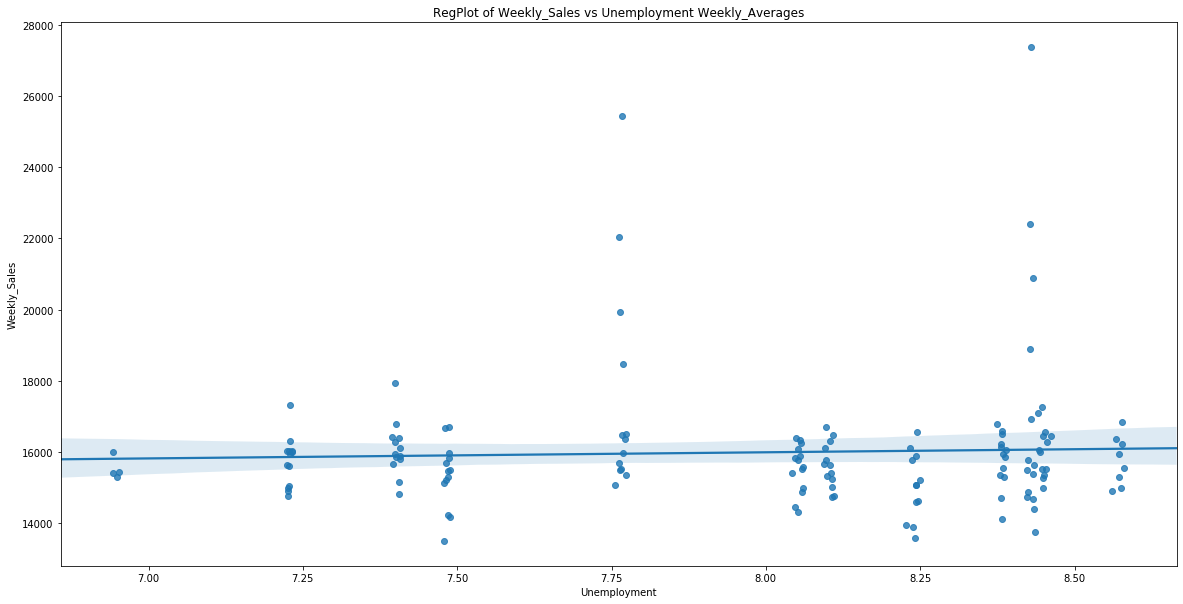

In [172]:
sns.regplot(x='Unemployment',y='Weekly_Sales',data=train_data.groupby('Date')[['Unemployment','Weekly_Sales']].mean().reset_index()).set_title('RegPlot of Weekly_Sales vs Unemployment Weekly_Averages')

A flat line shows no relation

In [173]:
from scipy.stats import pearsonr
corr,p = pearsonr(train_data.Weekly_Sales,train_data.Unemployment)
print('Correlation b/w WeeklySales and Unemployement = %0.3f' % corr)

Correlation b/w WeeklySales and Unemployement = -0.026


Which is negligible

## Size

Text(0.5, 1.0, 'Density plot for the Store Sizes')

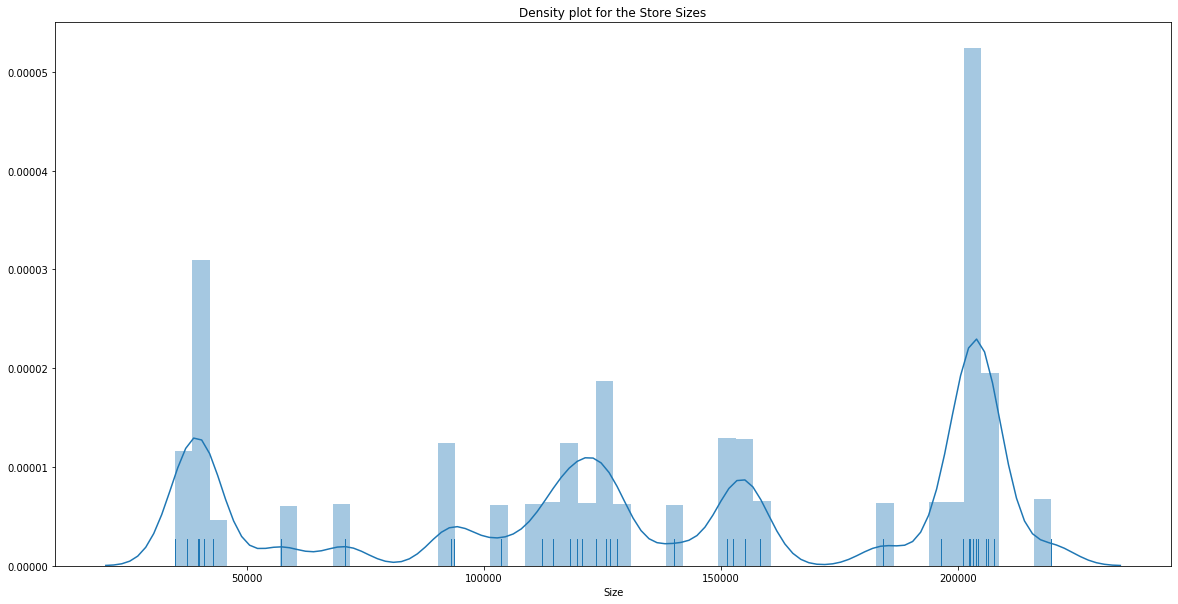

In [174]:
sns.distplot(a=train_data.Size,rug=True).set_title('Density plot for the Store Sizes')

In [175]:
train_data['Size_cat'] = np.where(train_data.Size<75000,'Small_Size',np.where(train_data.Size<175000,'Mid_Size','High_Size'))

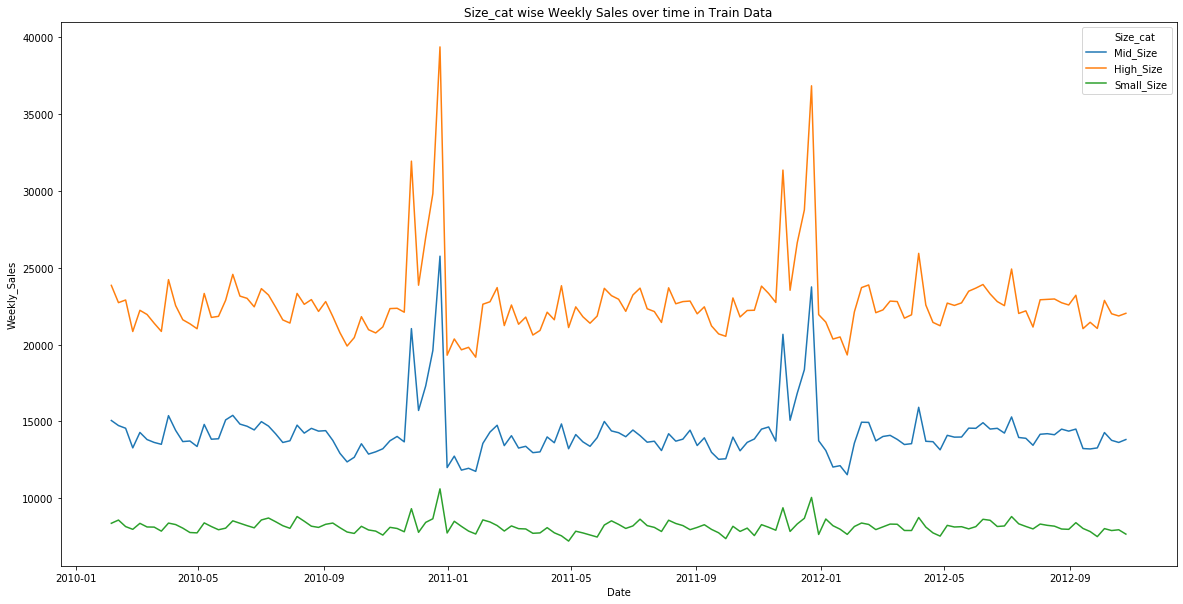

In [176]:
sns.lineplot(x='Date',y='Weekly_Sales',hue='Size_cat',data = train_data,ci=None).set_title('Size_cat wise Weekly Sales over time in Train Data');

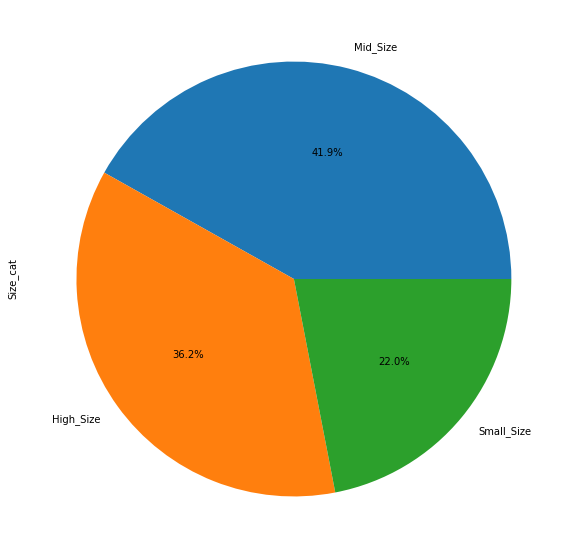

In [177]:
train_data['Size_cat'].value_counts().plot(kind='pie',autopct = "%2.1f%%");

In [178]:
corr,p = pearsonr(train_data.Weekly_Sales,train_data.Size)

In [179]:
corr

0.24382799226304272

The size of the store is also a good feature. It would make intuitive sense that the stores that are larger would make more sales as opposed to smaller ones. We can see a high correlation with the Weekly_Sales and the Size of the store.

## Pair plots

In [ ]:
g = sns.pairplot(train_data,vars=['Weekly_Sales', 'Fuel_Price', 'Size', 'CPI', 'Temperature', 'Unemployment'],kind='reg',plot_kws = {'ci':False});

In [ ]:
g = sns.pairplot(train_data,vars=['Weekly_Sales', 'Fuel_Price', 'Size', 'CPI', 'Temperature', 'Unemployment'], hue= 'Type',kind='reg');

In [ ]:
g = sns.pairplot(train_data,vars=['Weekly_Sales', 'Fuel_Price', 'Size', 'CPI', 'Temperature', 'Unemployment'], hue= 'CPI_cat',kind='reg');

In [ ]:
g = sns.pairplot(train_data,vars=['Weekly_Sales', 'Fuel_Price', 'Size', 'CPI', 'Temperature', 'Unemployment'], hue= 'Size_cat',kind='reg');

## Correlation Matrix

In [180]:
corr_mat = train_data.corr()
corr_mat.style.background_gradient(cmap='coolwarm')

,Store,Dept,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Store,1,0.0240037,-0.085195,-0.000547988,-0.182881,-0.0500969,0.0652902,-0.119588,-0.0351727,-0.0315555,-0.00994074,-0.026634,-0.211088,0.208552
Dept,0.0240037,1,0.148032,0.000916102,-0.00296646,0.00443652,0.00357198,-0.00242641,0.00029049,0.00178401,0.00425665,0.000108599,-0.00747739,0.00783677
Weekly_Sales,-0.085195,0.148032,1,0.0127742,0.243828,-0.00231245,-0.000120296,0.0852512,0.0241296,0.0603848,0.0454144,0.0903621,-0.0209213,-0.0258637
IsHoliday,-0.000547988,0.000916102,0.0127742,1,0.000593038,-0.155949,-0.0782811,-0.0355865,0.334818,0.42796,-0.000561807,-0.0537193,-0.00194351,0.0104595
Size,-0.182881,-0.00296646,0.243828,0.000593038,1,-0.0583129,0.00336119,0.345673,0.108827,0.0489127,0.168196,0.304575,-0.00331436,-0.0682383
Temperature,-0.0500969,0.00443652,-0.00231245,-0.155949,-0.0583129,1,0.143859,-0.0405942,-0.323927,-0.0968798,-0.0639465,-0.0175442,0.182112,0.0967302
Fuel_Price,0.0652902,0.00357198,-0.000120296,-0.0782811,0.00336119,0.143859,1,0.0613708,-0.220895,-0.102092,-0.044986,-0.128065,-0.16421,-0.0338527
MarkDown1,-0.119588,-0.00242641,0.0852512,-0.0355865,0.345673,-0.0405942,0.0613708,1,0.0244862,-0.108115,0.819238,0.160257,-0.0555576,0.0502853
MarkDown2,-0.0351727,0.00029049,0.0241296,0.334818,0.108827,-0.323927,-0.220895,0.0244862,1,-0.0501084,-0.0077678,-0.00743962,-0.0395343,0.0209399
MarkDown3,-0.0315555,0.00178401,0.0603848,0.42796,0.0489127,-0.0968798,-0.102092,-0.108115,-0.0501084,1,-0.0710955,-0.0264674,-0.0235903,0.0128178


The correllogram shows that only Dept and Size have a correlation with the Weekly Sales target feature that is greater than 0.1. However collinearity exists in some features.

## EDA Conclusion

From the analysis we can conclude the following:
1. Weekly Sales should be transformed to the logrithmic scale so that the distribution isnt as skewed
2. The variables Size, CPI and Type are good distinguishers of WeeklySales data
3. Some mechanism needs to be developed to cater for the missing data, particularly in the MarkdownColumns
4. Weekly sales Outliers problem is somewhat sorted by transforming to the logarithmic scale, however, there might still be need to look into outliers that appear the scale change. This can be done in the modeling process 
5. Some more features can also be engineered however their effectiveness can only be judged when making predictions.

# Statistical Analysis

## Testing for stationarity

The sales predicting problem can also be approached by treating it like a time series. Most of the time series models, require that the data be non-stationary. We test for the assumption of stationarity in the series 

In [181]:
weekly_sales_series = train_data.groupby('Date').Weekly_Sales.mean()

In [182]:
from statsmodels.tsa.stattools import adfuller

X = weekly_sales_series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.930803
p-value: 0.000000
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


Given the ADF Statistic is negative with a low P-values therefore, we reject the H0 that the series is Stationary

### Series Decomposition

In [183]:
store_date_sales = train_data[['Store','Dept','Date','Weekly_Sales']]

In [184]:
datewise_sales = train.groupby('Date')['Weekly_Sales','IsHoliday'].mean()

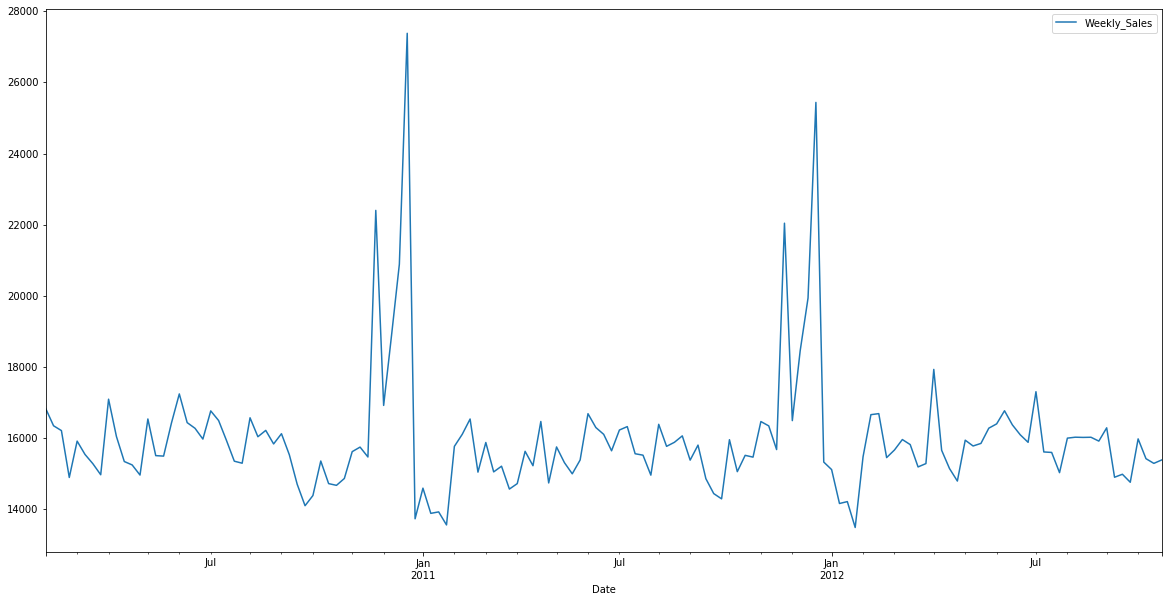

In [185]:
datewise_sales.plot()

In [186]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = (datewise_sales['Weekly_Sales'])
result = seasonal_decompose(series, model='additive',two_sided=False,extrapolate_trend='freq',freq=7)

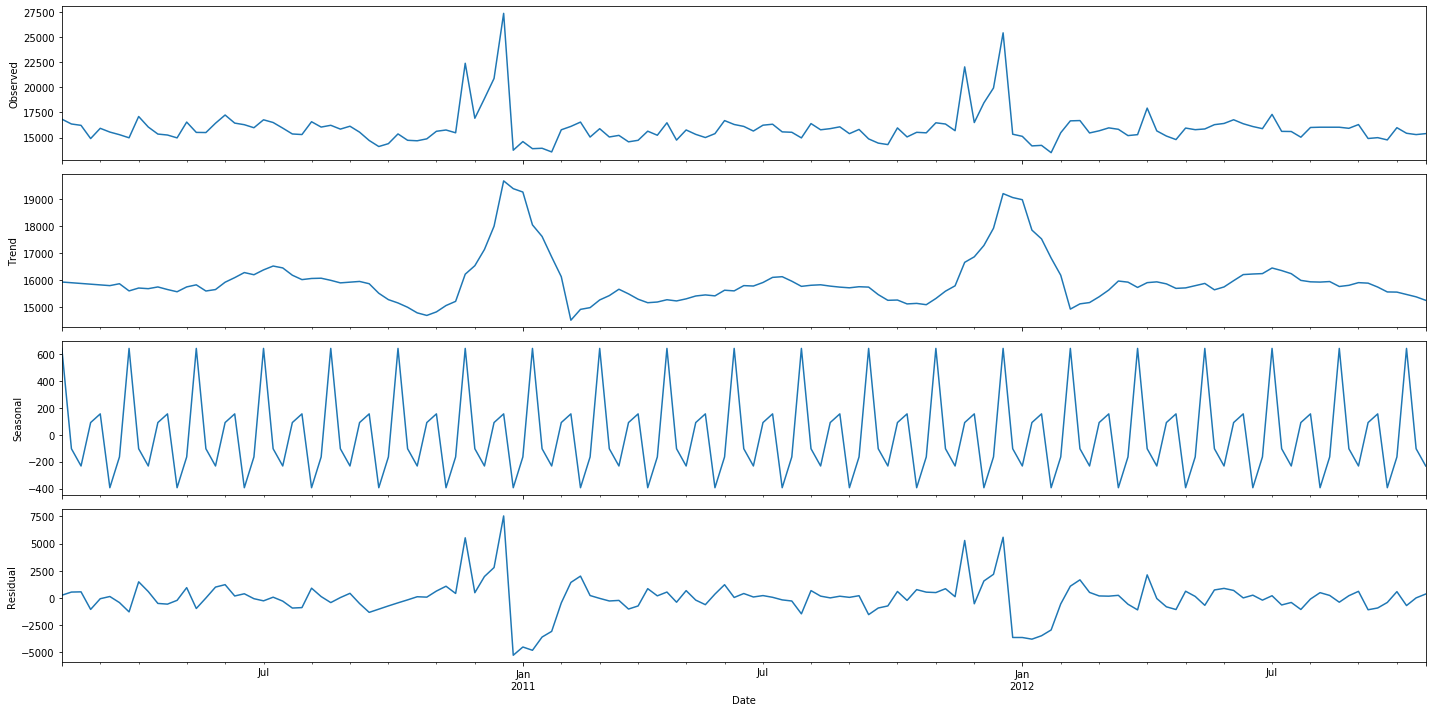

In [187]:
result.plot();

Decomposed series shows that the observed series is goverened majorly by the trend which spikes during the months of Dec - Jan. We also see that the highest residual values are during that period as well. Other than that we notice an intra monthly seasonal trend.

In [188]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

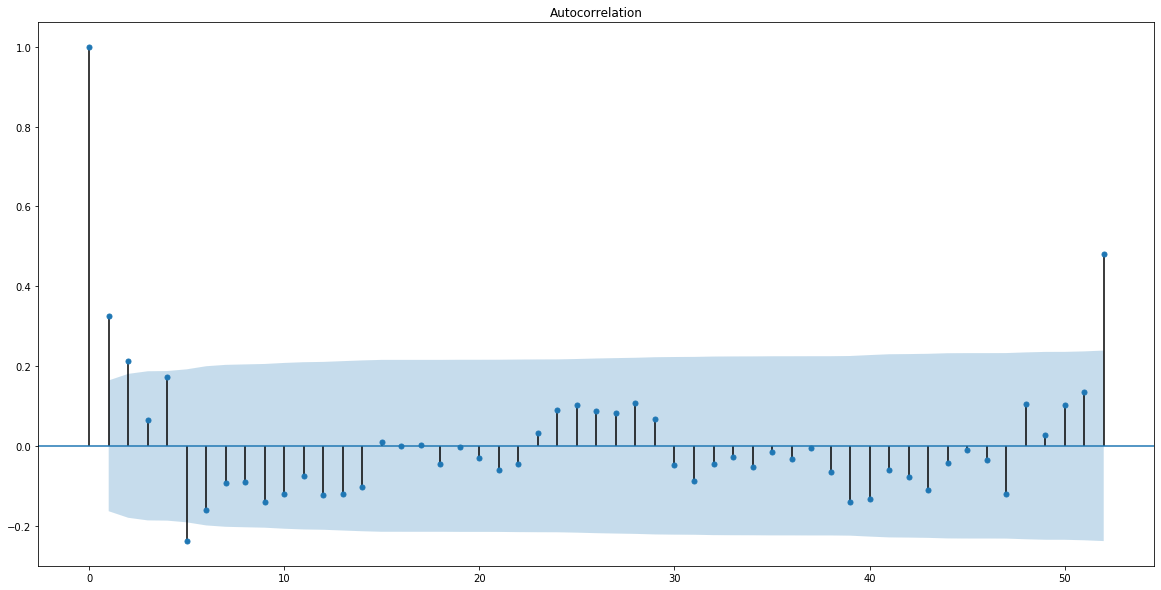

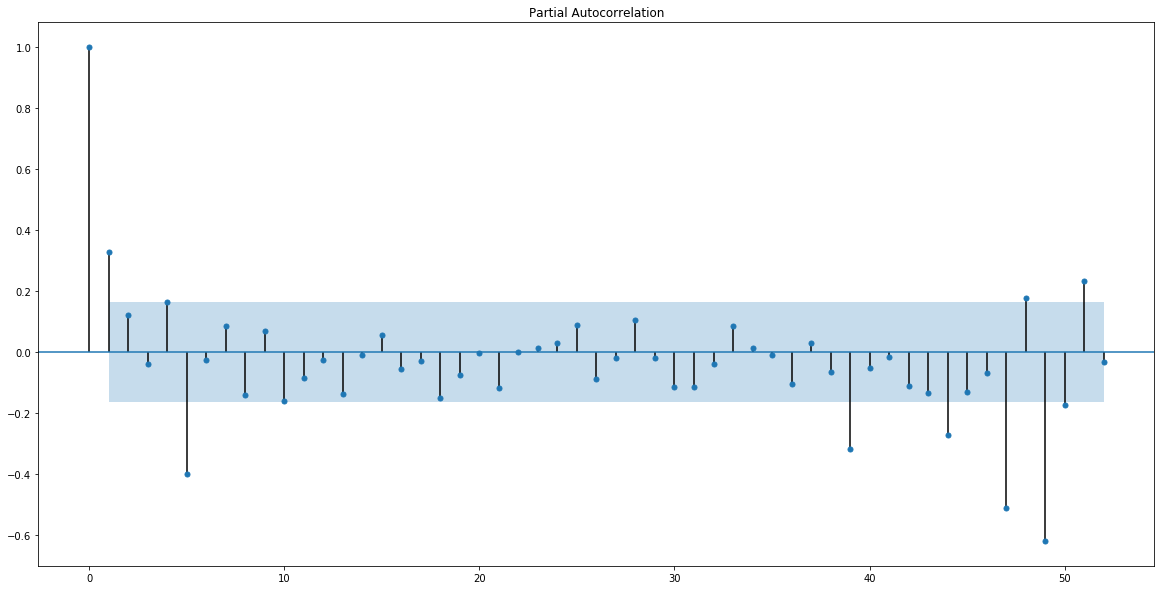

In [189]:
plot_acf(datewise_sales.Weekly_Sales.tolist(),lags=52);
plot_pacf(datewise_sales.Weekly_Sales.tolist(),lags = 52);

Looking at the Autocorrelation plot, we can see that the past sales lag of 1-14 weeks,week 26-29, and week 48-52are most correlated with the current weekly sales. I will create features according to these.  

# CPI - Weekly_Sales

In one of the above sections we explored the distribution of the feature CPI and converted it into a categorical feature with values HighCPI and LowCPI. *(Graph below)*

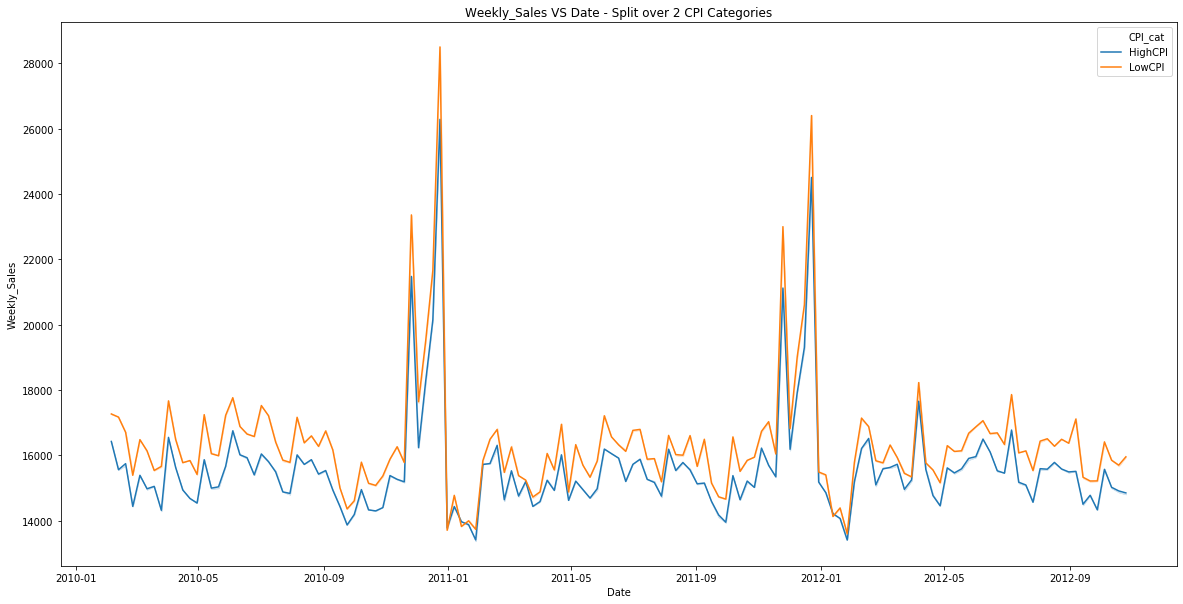

In [190]:
sns.lineplot(x='Date',y='Weekly_Sales',hue='CPI_cat',data = train_data,ci=False).set_title('Weekly_Sales VS Date - Split over 2 CPI Categories');

We can see that the LowCPI Sales are consistently higher than HighCPI store. We will try to conduct a statistical test in order to ascertain our observation

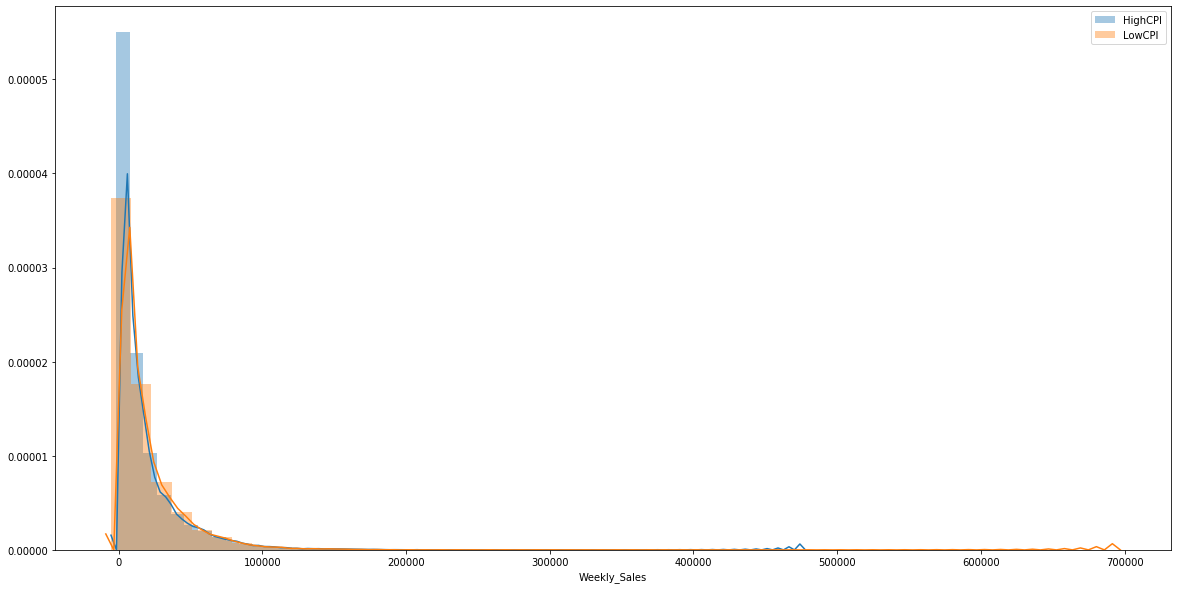

In [191]:
sns.distplot((train_data[train_data.CPI_cat=='HighCPI'].Weekly_Sales),label='HighCPI')
sns.distplot((train_data[train_data.CPI_cat=='LowCPI'].Weekly_Sales),label='LowCPI')
plt.legend()

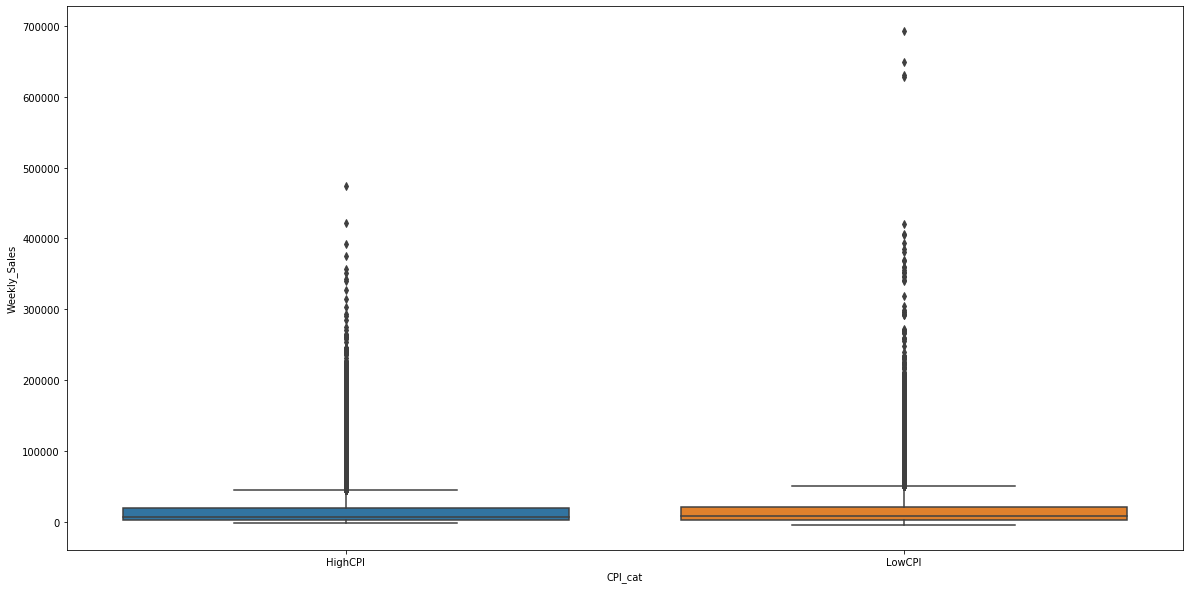

In [192]:
sns.boxplot(y='Weekly_Sales',x='CPI_cat',data=train_data)

It is not possible to notice the difference between the means of the categories in question by eyeing the distribution and the boxplots. We will use a t-test to test our hypothesis that these values are different.

H0 : No difference in means 

HA : Significant difference in means

In [193]:
var_high = train_data.query('CPI_cat=="HighCPI"').Weekly_Sales.std()
var_low = train_data.query('CPI_cat=="LowCPI"').Weekly_Sales.std()

var_high,var_low

(22785.414822190585, 22627.466173279936)

Standard deviations of both categories are approx equal

In [194]:
from scipy.stats import t,ttest_ind


stat,p = ttest_ind(train_data[train_data.CPI_cat=='HighCPI'].Weekly_Sales,
          train_data[train_data.CPI_cat=='LowCPI'].Weekly_Sales,equal_var=True)

p

1.705396374374582e-30

H0 : No difference in means 

HA : Significant difference in means

**p-value is very very small which should conclude that the means arent equal and thus CPI_Cat should be a good feature to predict the weekly_sales**